In [603]:
%pylab inline
plt.style.use('dark_background')
pylab.rcParams['figure.figsize'] = (10.0, 6.0)
matplotlib.rcParams['animation.embed_limit'] = 2**128

Populating the interactive namespace from numpy and matplotlib


In [604]:
# Potential functions
def force_goal(x, y, goal):
    goal_x, goal_y, k_goal = goal
    Fx_goal, Fy_goal = k_goal * (goal_x - x), k_goal *(goal_y - y)
    return Fx_goal, Fy_goal

def force_obstacle(x, y, obstacle):
    (obs_x, obs_y, k_obs) = obstacle
    dist_x, dist_y = x - obs_x, y - obs_y
    dist_obs = np.hypot(dist_x, dist_y)
    Fx_obs = (dist_x / dist_obs) * k_obs / dist_obs ** 3
    Fy_obs = (dist_y / dist_obs) * k_obs / dist_obs ** 3

    return Fx_obs, Fy_obs

def total_force(x, y, goal, obstacles):
    Fx, Fy = force_goal(x, y, goal)

    for obs in obstacles:
        Fo_x, Fo_y = force_obstacle(x, y, obs)
        Fx += Fo_x
        Fy += Fo_y
    return Fx, Fy

def plot_vector_field(ax=plt, fmax = .7):
    X, Y = np.meshgrid(np.arange(-10, 10, .3), np.arange(-10, 10, .3))

    # Vector field of the forces
    Fx, Fy = total_force(X, Y, goal, obstacles)

    # For visualization
    F_m = np.hypot(Fx, Fy)
    Fx[F_m > fmax], Fy[F_m > fmax] = None, None
    # Plot
    # quiver(X, Y, Fx, Fy,  F_m, color='0.4', scale=None)
    ax.quiver(X, Y, Fx, Fy, color='0.4')

def simulate(q, goal, obstacles, num_steps=200, delta_time=1.9):
    trajectory = []
    for i in range(num_steps):
        force = total_force(q[0], q[1], goal, obstacles)
        # Robot velocity follows the force vector
        vel = np.array(force)
        # Integrate
        q += vel * delta_time
        trajectory.append(np.copy(q))

    
    return np.array(trajectory)

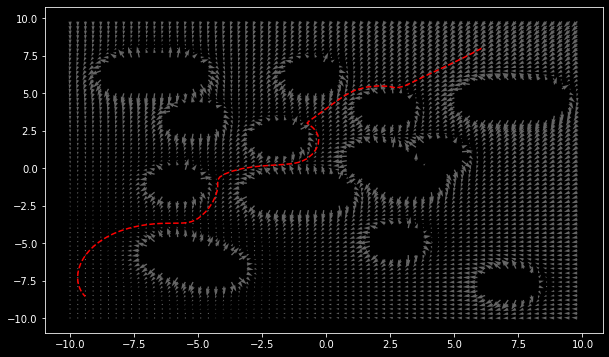

In [605]:
goal = [-8.425, -7.925, 0.02]

obstacles = [[-0.525, 6.3, 0.7],
             [2.425, 4.075, 0.7],
             [-5.125, 3.425, 0.7],
             [-1.775, 2.1, 0.7],
             [4.4, 0.875, 0.7],
             [-5.8, -0.975, 0.7],
             [2.825, -4.85, 0.7],
             [7.275, -7.75, 0.7],
             [-7.7, 6.4, 0.7],
             [-6.7, 6.4, 0.7],
             [-5.7, 6.4, 0.7],
             [6.425, 4.725, 0.7],
             [7.425, 4.725, 0.7],
             [8.425, 4.725, 0.7],
             [-2.025, -1.5, 0.7],
             [-1.025, -1.5, 0.7],
             [0.025, -1.5, 0.7],
             [1.95895556, 0.64278734, 0.7],
             [2.725, -0.00000027, 0.7],
             [3.49104444, -0.64278788, 0.7],
             [-6.0160254, -5.7, 0.7],
             [-5.15, -6.2, 0.7],
             [-4.2839746, -6.7, 0.7],
              ]

q = np.array((6.625, 8.55))

trajectory = simulate(q, goal, obstacles)
plot(trajectory[:,0], trajectory[:,1], 'r--')
plot_vector_field()

In [606]:
import sim
sim.simxFinish(-1)  # Close opened connections
clientID = sim.simxStart('127.0.0.1', 19999, True, True, 5000, 5)  # Connect to CoppeliaSim

if clientID != -1:
    print('Connected')

    # Now try to retrieve data in a blocking fashion (i.e. a service call):
    res, objs = sim.simxGetObjects(clientID, sim.sim_handle_all, sim.simx_opmode_blocking)

    print('Simulation time in milliseconds: ', sim.simxGetLastCmdTime(clientID))
    
    # Get Object position
    name = 'Quadricopter'
    err_code, cuboid = sim.simxGetObjectHandle(clientID, name, sim.simx_opmode_blocking)
    res, position = sim.simxGetObjectPosition(clientID, cuboid, -1, sim.simx_opmode_blocking)        
    print('Quadricopter is at [x,y,z]=', position)
    
    # Now close the connection to CoppeliaSim:
    sim.simxGetPingTime(clientID)
    sim.simxFinish(clientID)
    print('Disconnected')
else:
    print('Failed connecting to remote API server')

Connected
Simulation time in milliseconds:  20850
Quadricopter is at [x,y,z]= [2.016317129135132, 0.32518893480300903, 36.952423095703125]
Disconnected


In [607]:
class robot():

    def __init__(self, frame_name, motor_names=[], client_id=0):
        # If there is an existing connection
        if client_id:
                self.client_id = client_id
        else:
            self.client_id = self.open_connection()

        self.motors = self._get_handlers(motor_names)

        # Robot frame
        self.frame =  self._get_handler(frame_name)

    def open_connection(self):
        sim.simxFinish(-1)  # just in case, close all opened connections
        self.client_id = sim.simxStart('127.0.0.1', 19999, True, True, 5000, 5)  # Connect to CoppeliaSim

        if clientID != -1:
            print('Robot connected')
        else:
            print('Connection failed')
        return clientID

    def close_connection(self):
        # Before closing the connection to CoppeliaSim, make sure that the last command sent out had time to arrive.
        sim.simxGetPingTime(self.client_id)
        # Now close the connection to CoppeliaSim:
        sim.simxFinish(self.client_id)
        print('Connection closed')

    def isConnected(self):
        c,result = sim.simxGetPingTime(self.client_id)
        # Return true if the robot is connected
        return result > 0

    def _get_handler(self, name):
        err_code, handler = sim.simxGetObjectHandle(self.client_id, name, sim.simx_opmode_blocking)
        return handler

    def _get_handlers(self, names):
        handlers = []
        for name in names:
            handler = self._get_handler(name)
            handlers.append(handler)

        return handlers

    def send_motor_velocities(self, vels):
        for motor, vel in zip(self.motors, vels):
            err_code = sim.simxSetJointTargetVelocity(self.client_id,
                                                      motor, vel, sim.simx_opmode_streaming)

    def set_position(self, position, relative_object=-1):
        if relative_object != -1:
            relative_object = self._get_handler(relative_object)
        sim.simxSetObjectPosition(clientID, self.frame, relative_object, position, sim.simx_opmode_oneshot)

    def simtime(self):
        return sim.simxGetLastCmdTime(self.client_id)

    def get_position(self, relative_object=-1):
        # Get position relative to an object, -1 for global frame
        if relative_object != -1:
            relative_object = self._get_handler(relative_object)
        res, position = sim.simxGetObjectPosition(self.client_id, self.frame, relative_object, sim.simx_opmode_blocking)
        return array(position)

    def get_object_position(self, object_name):
        # Get Object position in the world frame
        err_code, object_h = sim.simxGetObjectHandle(self.client_id, object_name, sim.simx_opmode_blocking)
        res, position = sim.simxGetObjectPosition(self.client_id, object_h, -1, sim.simx_opmode_blocking)
        return array(position)

    def get_object_relative_position(self, object_name):
        # Get Object position in the robot frame
        err_code, object_h = sim.simxGetObjectHandle(self.client_id, object_name, sim.simx_opmode_blocking)
        res, position = sim.simxGetObjectPosition(self.client_id, object_h, self.frame, sim.simx_opmode_blocking)
        return array(position)
    
def move_robot(goal, obstacles, motor_names, robot_name):
    # Joint name in coppelia
    r = robot(robot_name, motor_names)  # Create an instance of our robot

    while True:
        # Sensing
        q = r.get_position()

        # Trajectory
        u = total_force(q[0], q[1], goal, obstacles)

        vx, vy = u
        r.send_motor_velocities([-vy - vx, vy - vx, vy + vx, -vy + vx])
        
        if (q[0] == goal[0] and q[1] == goal[1]):
            break

    r.send_motor_velocities([0, 0, 0, 0])
    r.close_connection()

In [608]:
motor_names = ['Omnirob_FLwheel_motor', 'Omnirob_FRwheel_motor', 'Omnirob_RRwheel_motor', 'Omnirob_RLwheel_motor']
robot_name = 'Omnirob'
k1 = 2
k2 = 70
goal00 = [-8.425, -7.925, k1]
obstacles00 = [[-0.525, 6.3, k2],
             [2.425, 4.075, k2],
             [-5.125, 3.425, k2],
             [-1.775, 2.1, k2],
             [4.4, 0.875, k2],
             [-5.8, -0.975, k2],
             [2.825, -4.85, k2],
             [7.275, -7.75, k2],
             [-7.7, 6.4, k2],
             [-6.7, 6.4, k2],
             [-5.7, 6.4, k2],
             [6.425, 4.725, k2],
             [7.425, 4.725, k2],
             [8.425, 4.725, k2],
             [-2.025, -1.5, k2],
             [-1.025, -1.5, k2],
             [0.025, -1.5, k2],
             [1.95895556, 0.64278734, k2],
             [2.725, -0.00000027, k2],
             [3.49104444, -0.64278788, k2],
             [-6.0160254, -5.7, k2],
             [-5.15, -6.2, k2],
             [-4.2839746, -6.7, k2],
              ]
move_robot(goal00, obstacles00, motor_names, robot_name)

Robot connected


KeyboardInterrupt: 